# Libraries

In [51]:
# Imports
import pandas as pd
import os
import flair
import torch
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.utils import shuffle
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from simpletransformers.classification import ClassificationModel
import logging
import sklearn
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from datetime import datetime

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.utils import resample # downsample etc

from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import KFold,cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# ML models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE

cwd = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
# nlp libs
import re

import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import nltk
nltk.download('stopwords')
nltk.download('punkt') # for stemming
nltk.download('wordnet') # for lemmatizing
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jmarcoglie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load Data

In [101]:
# https://www.kaggle.com/utkarshxy/stock-markettweets-lexicon-data - 9917 labelled tweets
stock_data_file = os.getcwd() + "\\Data\\stock_data.csv"
stock_data = pd.read_csv(stock_data_file)
stock_data= stock_data.rename(columns=str.lower)
stock_data.dropna(inplace=True)
print(stock_data)

# https://www.kaggle.com/yash612/stockmarket-sentiment-dataset - 5791 labelled tweets
tweets_data_file = os.getcwd() + "\\Data\\tweets_labelled.csv"
tweets_data = pd.read_csv(tweets_data_file, delimiter=';')
tweets_data.drop(columns=['id','created_at'], inplace=True)
tweets_data.dropna(inplace=True)
print(tweets_data)

# combine
dataset_frames = [stock_data, tweets_data]
dataset_frames_names = ["stock_data", "tweets_data"]
combined_df = result = pd.concat(dataset_frames)

                                                   text  sentiment
0     Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1     user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2     user I'd be afraid to short AMZN - they are lo...          1
3                                     MNTA Over 12.00            1
4                                      OI  Over 21.37            1
...                                                 ...        ...
5786  Industry body CII said #discoms are likely to ...         -1
5787  #Gold prices slip below Rs 46,000 as #investor...         -1
5788  Workers at Bajaj Auto have agreed to a 10% wag...          1
5789  #Sharemarket LIVE: Sensex off day’s high, up 6...          1
5790  #Sensex, #Nifty climb off day's highs, still u...          1

[5791 rows x 2 columns]
                                                   text sentiment
0     RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...  positive
1     #SriLanka surcharge on fuel remov

## Text Pre-processing

### Definitions

In [54]:
def sentiment_to_label(sentiment):
    if sentiment == "positive" or sentiment == 1:
        return 1
    elif sentiment == "negative" or sentiment == -1 or sentiment == 0:
        return 0
    else:
        return pd.NA

porter_stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

lemmer=WordNetLemmatizer()
def lemmatizing_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [lemmer.lemmatize(word) for word in words]
    return words

# From Lab
df_new = combined_df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text

    return text

### Apply Cleaning

In [55]:
df_new['text'] = df_new['text'].apply(clean_text)
df_new['text'] = df_new['text'].str.replace('\d+', '')
df_new['sentiment'] = df_new['sentiment'].apply(sentiment_to_label)
df_new['sentiment'] = pd.to_numeric(df_new['sentiment'])
df_new.dropna(inplace=True)
df_new = shuffle(df_new)
df_new
df_new.head()

C:\Users\JMARCO~1\AppData\Local\Temp/ipykernel_7700/3874924955.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_new['text'] = df_new['text'].str.replace('\d+', '')


,text,sentiment
1003,short term bearish cyh goes parabolic upper ba...,0.0
7046,msft okay https tco vnibpzbbpw,0.0
5436,sense ends points higher nifty markets brea...,1.0
1860,amzn postearnings eversal,0.0
6365,everyday #optimism + market open sp ndfutures ...,1.0


1.0    4213
0.0    2454
Name: sentiment, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'sentiment')

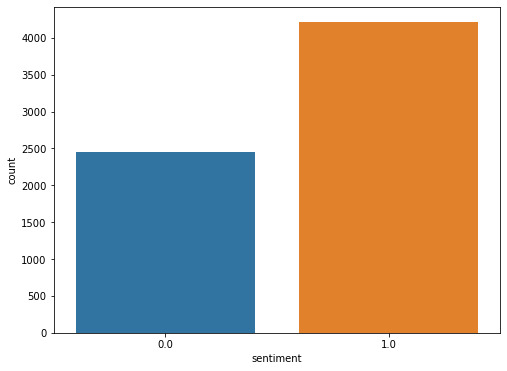

In [56]:
print(df_new['sentiment'].value_counts())
rcParams['figure.figsize'] = 8, 6
sns.countplot(df_new.sentiment)
plt.xlabel('sentiment')

### Adjust inbalanced set (Pick one)

In [84]:
# rus = RandomUnderSampler(random_state=42)
# X_res, y_res = rus.fit_resample(df_new['text'].to_numpy().reshape(-1, 1), df_new['sentiment'])
# print('Resampled dataset shape %s' % Counter(y_res))
# X = X_res.flatten()
# y = [int(x) for x in y_res]

# rus = RandomOverSampler(random_state=42)
# X_res, y_res = rus.fit_resample(df_new['text'].to_numpy().reshape(-1, 1), df_new['sentiment'])
# print('Resampled dataset shape %s' % Counter(y_res))
# X = X_res.flatten()
# y = [int(x) for x in y_res]

X = df_new['text']
y = [int(x) for x in df_new['sentiment']]

In [58]:
count_vect = CountVectorizer(tokenizer=stemming_tokenizer)
X_binary_counts = count_vect.fit_transform(X)
print("X_binary_counts.shape", X_binary_counts.shape)
print("X_binary_counts[20]:\n%s" %X_binary_counts[20])
print("X_binary_counts.toarray()[0]", X_binary_counts.toarray()[0])
print("len(X_binary_counts.toarray()[0])", len(X_binary_counts.toarray()[0]))
print("max(X_binary_counts.toarray()[0])", max(X_binary_counts.toarray()[0]))

X_binary_counts.shape (6667, 9879)
X_binary_counts[20]:
  (0, 9795)	1
  (0, 8404)	1
X_binary_counts.toarray()[0] [0 0 0 ... 0 0 0]
len(X_binary_counts.toarray()[0]) 9879
max(X_binary_counts.toarray()[0]) 1


##### TF-IDF

In [59]:
tfidf_transformer = TfidfTransformer()

X_tfidf_binary = tfidf_transformer.fit_transform(X_binary_counts)
print("X_tfidf_binary.shape", X_tfidf_binary.shape)
X_all_binary = X_tfidf_binary.toarray()
X_all_binary

X_tfidf_binary.shape (6667, 9879)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### Smote Oversampling (INSTEAD OF EARLIER UNDER/OVER SAMPLING)

In [60]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_all_binary, y)
print('SMOTE oversamples dataset shape %s' % Counter(y_res))
print("X_res.shape", X_res.shape)
X_all_binary = X_res
y = [int(x) for x in y_res]

SMOTE oversamples dataset shape Counter({0: 4213, 1: 4213})
X_res.shape (8426, 9879)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### train-test split

In [61]:
d_test_size = 0.2
i_nTestPts_binary = int(d_test_size*len(X_all_binary))
print("i_nTestPts_binary", i_nTestPts_binary)

b_split_byIndex = False
if b_split_byIndex == True:    
    X_train_binary, X_test_binary, y_train_binary, y_test_binary = X_all_binary[:-i_nTestPts_binary], X_all_binary[-i_nTestPts_binary:], y[:-i_nTestPts_binary], y[-i_nTestPts_binary:]
else:
    X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_all_binary, y, test_size = d_test_size, random_state = 42)

X_train_binary = np.array(X_train_binary)
y_train_binary = np.array(y_train_binary)
y_test_binary = np.array(y_test_binary)
X_test_binary = np.array(X_test_binary)
print(X_train_binary.shape, y_train_binary.shape)
print(X_test_binary.shape, y_test_binary.shape)

i_nTestPts_binary 1685
(6740, 9879) (6740,)
(1686, 9879) (1686,)


# Running ML Algos

In [11]:
# # Feature extraction - Sentiment Analysis using bag-of-words approach # https://core.ac.uk/download/pdf/230446749.pdf page 16
# positive_ngrams = ['positive', 'buy', 'bull', 'boost','high','bullish','gain']
# negative_ngrams = ['negative', 'loss', 'drop', 'plummet', 'sell', 'bearish', 'bear']
# combined_ngrams = positive_ngrams + negative_ngrams
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform([positive_ngrams,negative_ngrams])

## SVM

#### SVM Grid Search

In [53]:
# very long run times
# parameters = {'C': [1, 10], 
#           'gamma': [0.001, 0.01, 1]}

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100], 
              'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10]}

model = SVC(random_state = 42)
grid = GridSearchCV(estimator=model, param_grid=parameters)
grid.fit(X_train_binary, y_train_binary)

print(grid)
# summarize the results of the grid search
print("best_score:%s" %grid.best_score_)
print("best_estimator:%s"%grid.best_estimator_)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
                         'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10]})
best_score:0.7600567251746325
best_estimator:SVC(C=10, gamma=1, random_state=42)


#### SVM Best Model

In [62]:
# very long run times
clf = SVC(C=50, gamma=1, random_state=42).fit(X_train_binary, y_train_binary)
y_pred = clf.predict(X_test_binary)
print("accuracy", round(accuracy_score(y_test_binary, y_pred),3))
print(classification_report(y_test_binary, y_pred))

accuracy 0.878
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       842
           1       0.87      0.89      0.88       844

    accuracy                           0.88      1686
   macro avg       0.88      0.88      0.88      1686
weighted avg       0.88      0.88      0.88      1686



## Other models

In [63]:
def RunTextClfModels_v2(gvModelNames, gvModels, gX_all, gy_all, ginFolds=3):
    ''' Get a list of models, data matrix X, target vector Y, and # of folds k
    Return ["RMSE", "R2", "MAE"] values (all values, averaged over k folds)
    '''

    print("RunTextClfModels_v2()")

    t_vMeasures = ["accuracy", "f1-score", "tr_time"]
    kfold_list = ["fold" + str(i) for i in list(range(ginFolds))] 

    # initialize the output dictionary
    output = dict((i,{}) for i in gvModelNames)
    for i in output:
        output[i] = dict((k,[]) for k in kfold_list)
        for k in output[i]:
            output[i][k] = dict((j,[]) for j in t_vMeasures)
    
    kf = KFold(n_splits = ginFolds)
    ctr = 0
    for train_index, test_index in kf.split(gX_all):
        
        # print("train_index:%s, test_index:%s" %(list(train_index), list(test_index)))

        print("--- start fold %d" %(ctr))
    
        # train/test split for k-fold cross-validation
        # X_train, X_test = gX_all.iloc[train_index], gX_all.iloc[test_index]
        # y_train, y_test = gy_all.iloc[train_index], gy_all.iloc[test_index]
        
        X_train, X_test = gX_all[train_index], gX_all[test_index]
        y_train, y_test = gy_all[train_index], gy_all[test_index]
    
        for index, value in enumerate(gvModelNames):
            
            print("--->>> start model %s" %(value))
            
            # model training/prediction
            start = datetime.now()
            model = gvModels[index]
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
    
            # store the model outcomes
            output[value]["fold"+str(ctr)]["accuracy"] = np.round(accuracy_score(y_test, y_pred),3)
            output[value]["fold"+str(ctr)]["f1-score"] = np.round(f1_score(y_test, y_pred, average='weighted'),3)
            output[value]["fold"+str(ctr)]["tr_time"] = np.round((datetime.now()-start).total_seconds(),3)
        ctr = ctr + 1
    
    return output

In [64]:
model_names = ["SVC", "MNB", "LogR", "RF", "SGD", "MLP"]
model_lib = [SVC(C=50, gamma=1, random_state=42), # modified 
             MultinomialNB(), 
             LogisticRegression(n_jobs=1, C=1e5), 
             RandomForestClassifier(random_state = 42), 
             SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None),
             MLPClassifier(random_state=42, max_iter=300)]

dic_ress = RunTextClfModels_v2(model_names, model_lib, X_all_binary, np.array(y), ginFolds=5)
# print(dic_ress)

pd_ress_bin = pd.DataFrame({(level1_key, level2_key): values
for level1_key, level2_dict in dic_ress.items()
for level2_key, values in level2_dict.items()}).T

pd_ress_bin = pd_ress_bin.reset_index()
pd_ress_bin.rename(columns={'level_0': 'Model', 'level_1': 'Fold'}, inplace=True)
pd_ress_bin

RunTextClfModels_v2()
--- start fold 0
--->>> start model SVC
--->>> start model MNB
--->>> start model LogR


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--->>> start model RF
--->>> start model SGD
--->>> start model MLP
--- start fold 1
--->>> start model SVC
--->>> start model MNB
--->>> start model LogR


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--->>> start model RF
--->>> start model SGD
--->>> start model MLP
--- start fold 2
--->>> start model SVC
--->>> start model MNB
--->>> start model LogR


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--->>> start model RF
--->>> start model SGD
--->>> start model MLP
--- start fold 3
--->>> start model SVC
--->>> start model MNB
--->>> start model LogR


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--->>> start model RF
--->>> start model SGD
--->>> start model MLP
--- start fold 4
--->>> start model SVC
--->>> start model MNB
--->>> start model LogR


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--->>> start model RF
--->>> start model SGD
--->>> start model MLP


,Model,Fold,accuracy,f1-score,tr_time
0,SVC,fold0,0.858,0.858,335.216
1,SVC,fold1,0.858,0.859,282.193
2,SVC,fold2,0.862,0.863,216.976
3,SVC,fold3,0.864,0.864,323.912
4,SVC,fold4,1.000,1.000,379.395
5,MNB,fold0,0.756,0.760,0.217
6,MNB,fold1,0.745,0.750,0.176
7,MNB,fold2,0.732,0.739,0.159
8,MNB,fold3,0.765,0.766,0.336
9,MNB,fold4,0.561,0.719,0.240


In [65]:
pd_ress_avg = np.round(pd_ress_bin.groupby(["Model"], as_index=False).mean(),3)
pd_ress_std = pd_ress_bin.groupby(["Model"], as_index=False).agg(np.std, ddof=0).round(3).drop("Fold", axis=1)
pd_ress_std.rename(columns={'accuracy': 'accuracy-std', 'f1-score': 'f1-score-std','tr_time': 'tr_time-std'}, inplace=True)

pd_ress_summary = pd.concat([pd_ress_avg, pd_ress_std], axis = 1).T.drop_duplicates().T.sort_index(axis=1, ascending=True)
pd_ress_summary

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3558: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Model,accuracy,accuracy-std,f1-score,f1-score-std,tr_time,tr_time-std
0,LogR,0.837,0.081,0.839,0.08,4.126,0.85
1,MLP,0.841,0.079,0.843,0.079,279.683,98.461
2,MNB,0.712,0.076,0.747,0.017,0.226,0.062
3,RF,0.823,0.057,0.83,0.069,86.71,62.2
4,SGD,0.695,0.137,0.73,0.069,0.955,0.308
5,SVC,0.888,0.056,0.889,0.056,307.538,54.848


# Deep Learning

In [85]:
from keras import preprocessing, layers, Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer

X = df_new['text']
y = [int(x) for x in df_new['sentiment']]

max_features = 10000
maxlen = 300

tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
encoded_docs = tokenizer.texts_to_sequences(X)

encoded_docs = preprocessing.sequence.pad_sequences(encoded_docs,maxlen=maxlen)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(encoded_docs, y)
print('SMOTE oversamples dataset shape %s' % Counter(y_res))
print("X_res.shape", X_res.shape)

x_train,x_test,y_train,y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

SMOTE oversamples dataset shape Counter({0: 4213, 1: 4213})
X_res.shape (8426, 300)


### Bidirectional RNN

In [92]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(np.array(x_train), np.array(y_train), epochs=10, batch_size=128, validation_split=0.2)
model.summary()

Epoch 1/10
43/43 [==============================] - 11s 218ms/step - loss: 0.6858 - accuracy: 0.5640 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 2/10
43/43 [==============================] - 11s 267ms/step - loss: 0.6275 - accuracy: 0.6751 - val_loss: 0.6276 - val_accuracy: 0.6810
Epoch 3/10
43/43 [==============================] - 11s 264ms/step - loss: 0.5526 - accuracy: 0.7533 - val_loss: 0.6327 - val_accuracy: 0.6343
Epoch 4/10
43/43 [==============================] - 12s 286ms/step - loss: 0.4862 - accuracy: 0.7932 - val_loss: 0.6770 - val_accuracy: 0.6387
Epoch 5/10
43/43 [==============================] - 13s 299ms/step - loss: 0.4444 - accuracy: 0.8134 - val_loss: 0.6328 - val_accuracy: 0.6766
Epoch 6/10
43/43 [==============================] - 13s 302ms/step - loss: 0.3767 - accuracy: 0.8457 - val_loss: 0.6432 - val_accuracy: 0.6758
Epoch 7/10
43/43 [==============================] - 13s 298ms/step - loss: 0.3272 - accuracy: 0.8657 - val_loss: 0.6578 - val_accuracy: 0.6632

[0.9037237167358398, 0.654211163520813]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


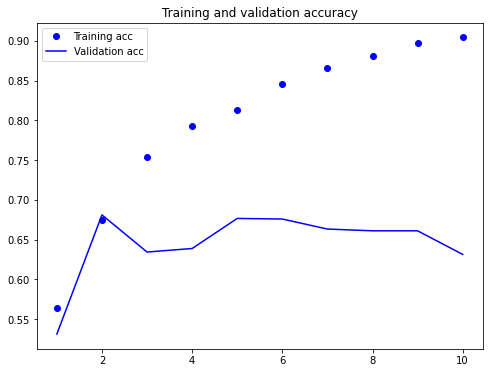

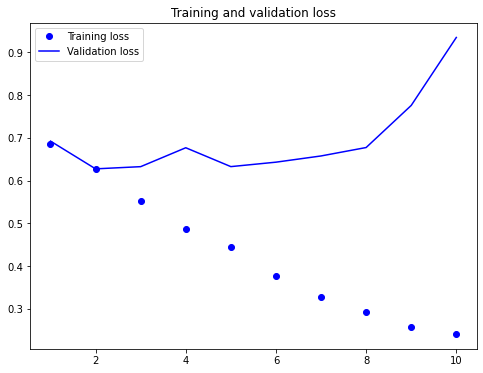

In [93]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [94]:
# Retraining over results from above
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(np.array(x_train), np.array(y_train), epochs=2, batch_size=128, validation_split=0.2)
test_loss, test_acc = model.evaluate(np.array(x_test), np.array(y_test))
print("test_loss: %s, test_acc: %s" %(np.round(test_loss,3), np.round(test_acc,3)))

Epoch 1/2
43/43 [==============================] - 10s 194ms/step - loss: 0.6862 - accuracy: 0.5619 - val_loss: 0.6735 - val_accuracy: 0.5935
Epoch 2/2
53/53 [==============================] - 1s 16ms/step - loss: 0.6227 - accuracy: 0.6738
test_loss: 0.623, test_acc: 0.674


### CNN

In [99]:
from keras.optimizers import rmsprop_v2
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(np.array(x_train), np.array(y_train), epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 128)          1280000   
                                                                 
 conv1d_4 (Conv1D)           (None, 294, 32)           28704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 58, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 52, 32)            7200      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


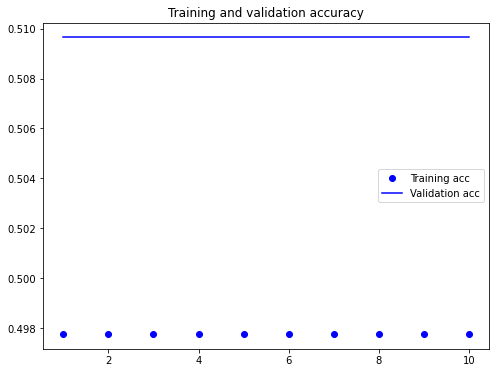

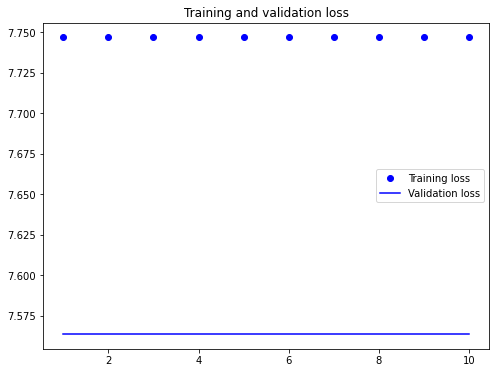

In [100]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Pre-Trained models

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

acc = 0
for test_point, y_actual in zip(X,y):
    score = sid.polarity_scores(test_point)["compound"]
    if((score >= 0 and int(y_actual) == 1) or (score < 0 and int(y_actual) == 0)):
        acc += 1
print("Accuracy:" + str(acc/len(X)))
    

Accuracy:0.6085982070089649


In [15]:
from textblob import TextBlob

acc = 0
for test_point, y_actual in zip(X,y):
    score = TextBlob(test_point).sentiment.polarity
    if((score >= 0 and int(y_actual) == 1) or (score < 0 and int(y_actual) == 0)):
        acc += 1
print("Accuracy:" + str(acc/len(X)))

Accuracy:0.539119804400978


In [16]:
# Feature extraction - Sentiment Analysis using XLNet (https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85)
# Using trained model generated by Google Colab notebook

# splitting the data into training and eval dataset
eval_df = pd.DataFrame(X)
eval_df['sentiment'] = y

# logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# They are lot of arguments to play with
'''
args = {
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',
   'fp16': True,
   'fp16_opt_level': 'O1',
   'max_seq_length': 256,
   'train_batch_size': 8,
   'eval_batch_size': 8,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 3,
   'weight_decay': 0,
   'learning_rate': 4e-5,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,
   'logging_steps': 50,
   'evaluate_during_training': False,
   'save_steps': 2000,
   'eval_all_checkpoints': True,
   'use_tensorboard': True,
   'overwrite_output_dir': True,
   'reprocess_input_data': False,
}
'''

# Create a ClassificationModel
model = ClassificationModel('xlnet', os.getcwd() +"\\Data\\xlnet\\checkpoint-844-epoch-4", args={'num_train_epochs':4, 'train_batch_size':32, 'max_seq_length':128},use_cuda=False) # You can set class weights by using the optional weight argument

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)
result
print("Warning: we're running training data back through")

C:\ProgramData\Anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1426: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 10/4908 [00:07<1:04:17,  1.27it/s]
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_2_2
Running Evaluation: 100%|██████████| 614/614 [19:34<00:00,  1.91s/it]
INFO:simpletransformers.classification.classification_model:{'mcc': 0.8781966817184593, 'tp': 2293, 'tn': 2316, 'fp': 138, 'fn': 161, 'auroc': 0.9801103964121582, 'auprc': 0.9804586851324036, 'acc': 0.939079054604727, 'eval_loss': 0.17472003288991775}


{'mcc': 0.8781966817184593,
 'tp': 2293,
 'tn': 2316,
 'fp': 138,
 'fn': 161,
 'auroc': 0.9801103964121582,
 'auprc': 0.9804586851324036,
 'acc': 0.939079054604727,
 'eval_loss': 0.17472003288991775}